In [35]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [37]:
data= pd.read_csv('/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv', delimiter='\t', quoting= 3)
data

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1


In [38]:
print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [39]:
data.columns.values

array(['rating', 'date', 'variation', 'verified_reviews', 'feedback'],
      dtype=object)

In [40]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [44]:
#Getting the record where 'verified_reviews' is null 

data[data[['rating', 'date', 'variation', 'verified_reviews', 'feedback']].isna().any(axis=1)]

,rating,date,variation,verified_reviews,feedback


# dropping that column

In [43]:
data.dropna(inplace=True)

In [45]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [47]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [50]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[570]['verified_reviews']}")
print(f"Length of review : {len(data.iloc[570]['verified_reviews'])}") 
print(f"'length' column value : {data.iloc[570]['length']}")

'verified_reviews' column value: "I took a chance on a certified refurbished unit for $29. Looks brand new...no excuses or disappointments. 5 minute trouble-free set up! Effortless bluetooth speaker connectivity through the Alexa App on my iPhone was flawless. Listening to my favorite tunes through a Bose Bluetooth setup and couldn't be happier. Walk through the door and just ask Alexa to: &#34;Play 80's music&#34; and viola... instant atmosphere! No more opening the iPad, going to settings, turning on bluetooth and then accessing the Pandora app. It just makes things so effortless. A true joy right out of the box! If I didn't discover any other uses for this fine piece of technology it was worth every penny!"
Length of review : 686
'length' column value : 686


In [51]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [52]:
print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


In [58]:
print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


In [54]:
data.describe()

,rating,feedback,length
count,3149.000000,3149.000000,3149.000000
mean,4.463957,0.918704,132.714513
std,1.067773,0.273332,182.541531
min,1.000000,0.000000,1.000000
25%,4.000000,1.000000,30.000000
50%,5.000000,1.000000,74.000000
75%,5.000000,1.000000,166.000000
max,5.000000,1.000000,2853.000000


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3149 non-null   int64 
 1   date              3149 non-null   object
 2   variation         3149 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3149 non-null   int64 
 5   length            3149 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 172.2+ KB


# EDA

# Rating

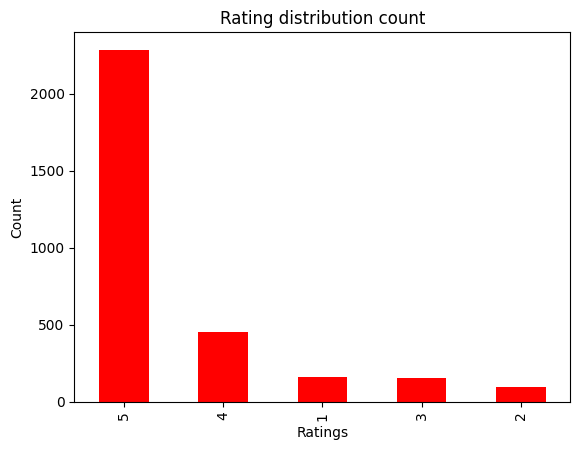

In [57]:
data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

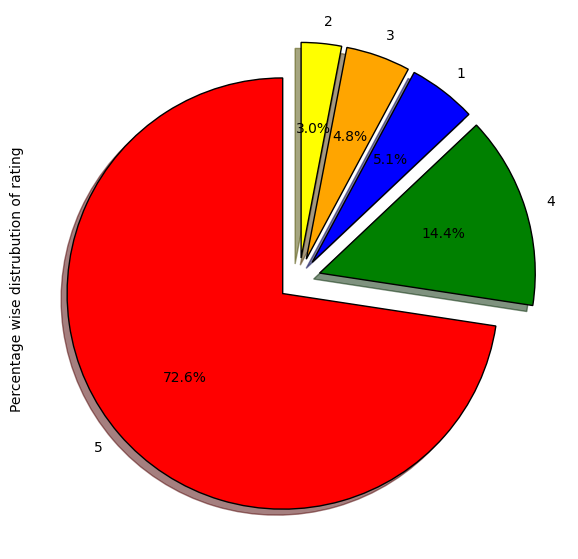

In [59]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue','orange','yellow')
wp = {'linewidth':1, "edgecolor":'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')
from io import  BytesIO
graph = BytesIO()
fig.savefig(graph, format="png")

# feedback

In [63]:
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [75]:
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [76]:
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [73]:
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


In [72]:
review_0 = data[data['feedback'] == 0].iloc[5]['verified_reviews']
print(review_0)
review_1 = data[data['feedback'] == 1].iloc[5]['verified_reviews']
print(review_1)

"Really disappointed Alexa has to be plug-in to wall socket all the time.  My fault for not checking this, but made the assumption that a company has technologically advanced as Amazon would sell this product with a rechargeable battery.  If I could return it, I would as my Apple music and boom speaker give me more flexibility the Alexa."
"I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do."


so we can say the 0 is for negativeand the 1 for positive

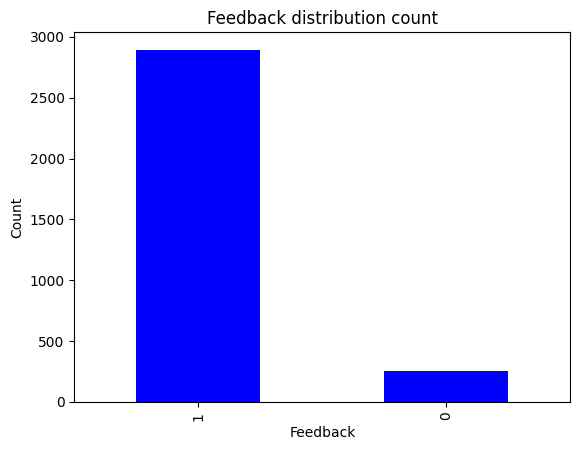

In [70]:
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

<Axes: ylabel='Percentage wise distrubution of feedback'>

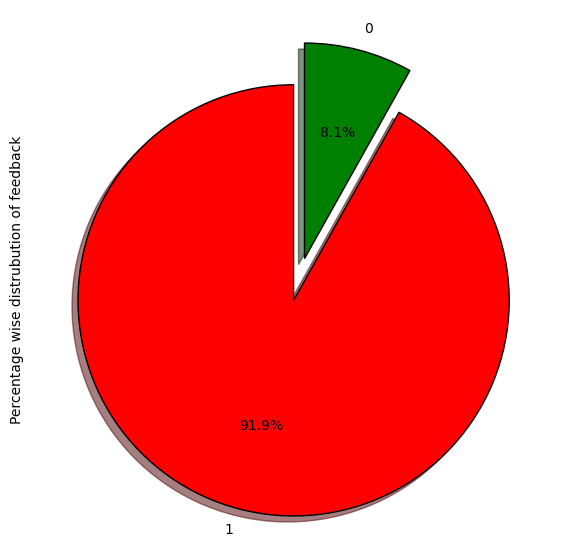

In [74]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green')
wp = {'linewidth':1, "edgecolor":'black'}
tags = data['feedback'].value_counts()/data.shape[0]
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

# variation

In [77]:
print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


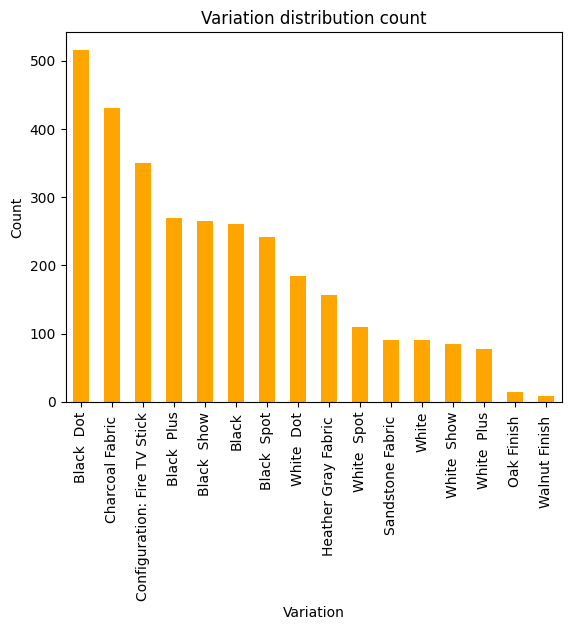

In [78]:
data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [79]:
print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [80]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

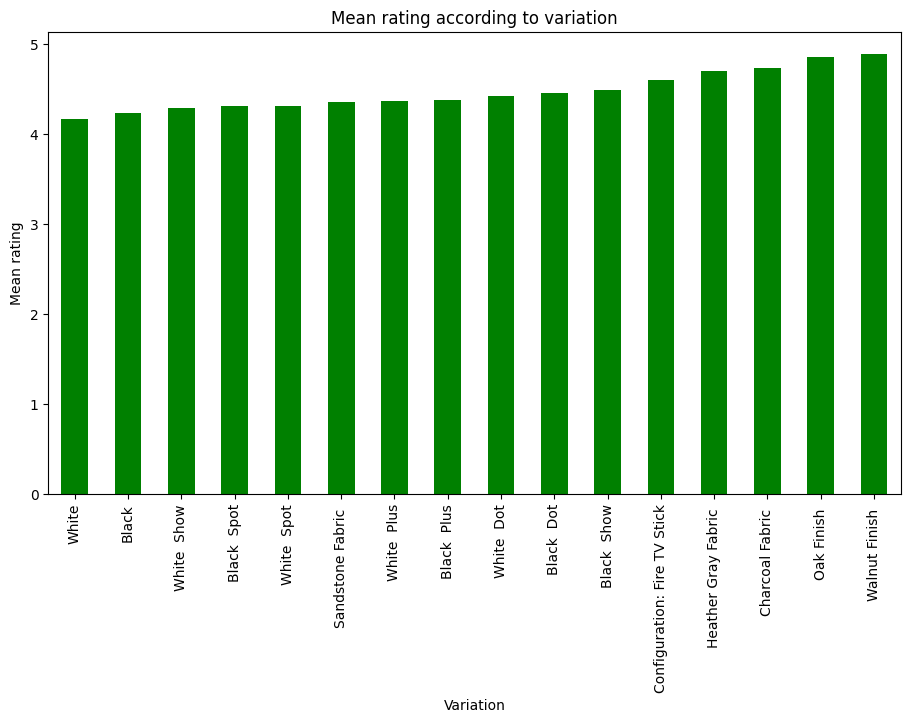

In [82]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'green', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

# Length

In [83]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review ')]

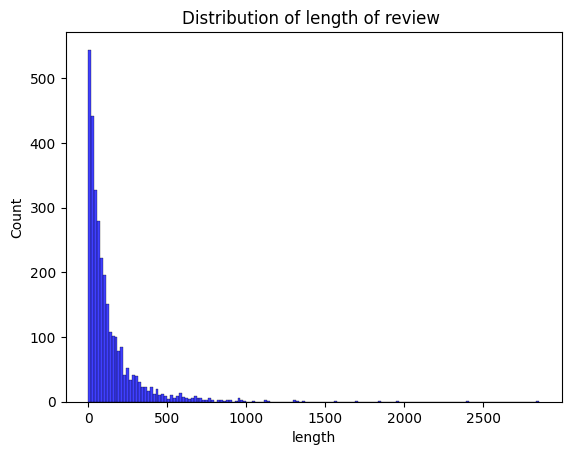

In [84]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

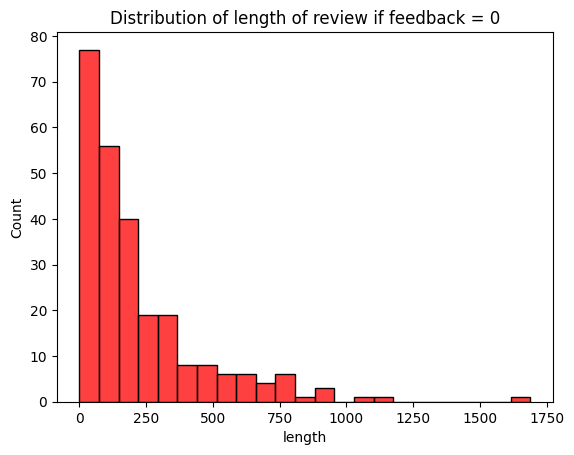

In [85]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

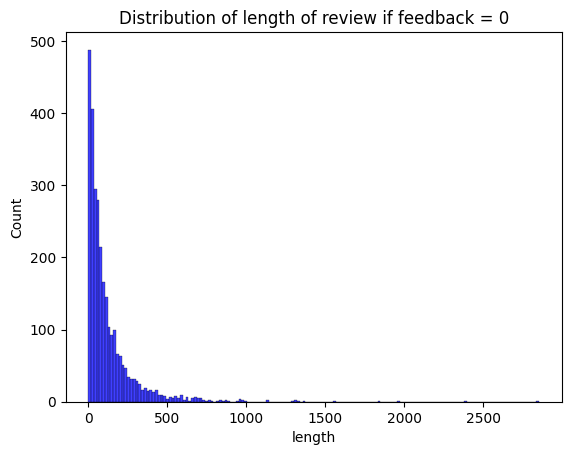

In [87]:
sns.histplot(data[data['feedback']==1]['length'],color='blue').set(title='Distribution of length of review if feedback = 0')

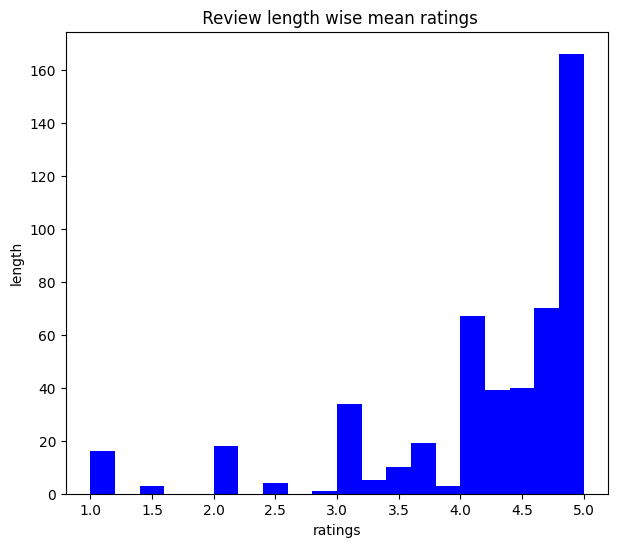

In [88]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [90]:
cv= CountVectorizer(stop_words='english')
words= cv.fit_transform(data.verified_reviews)

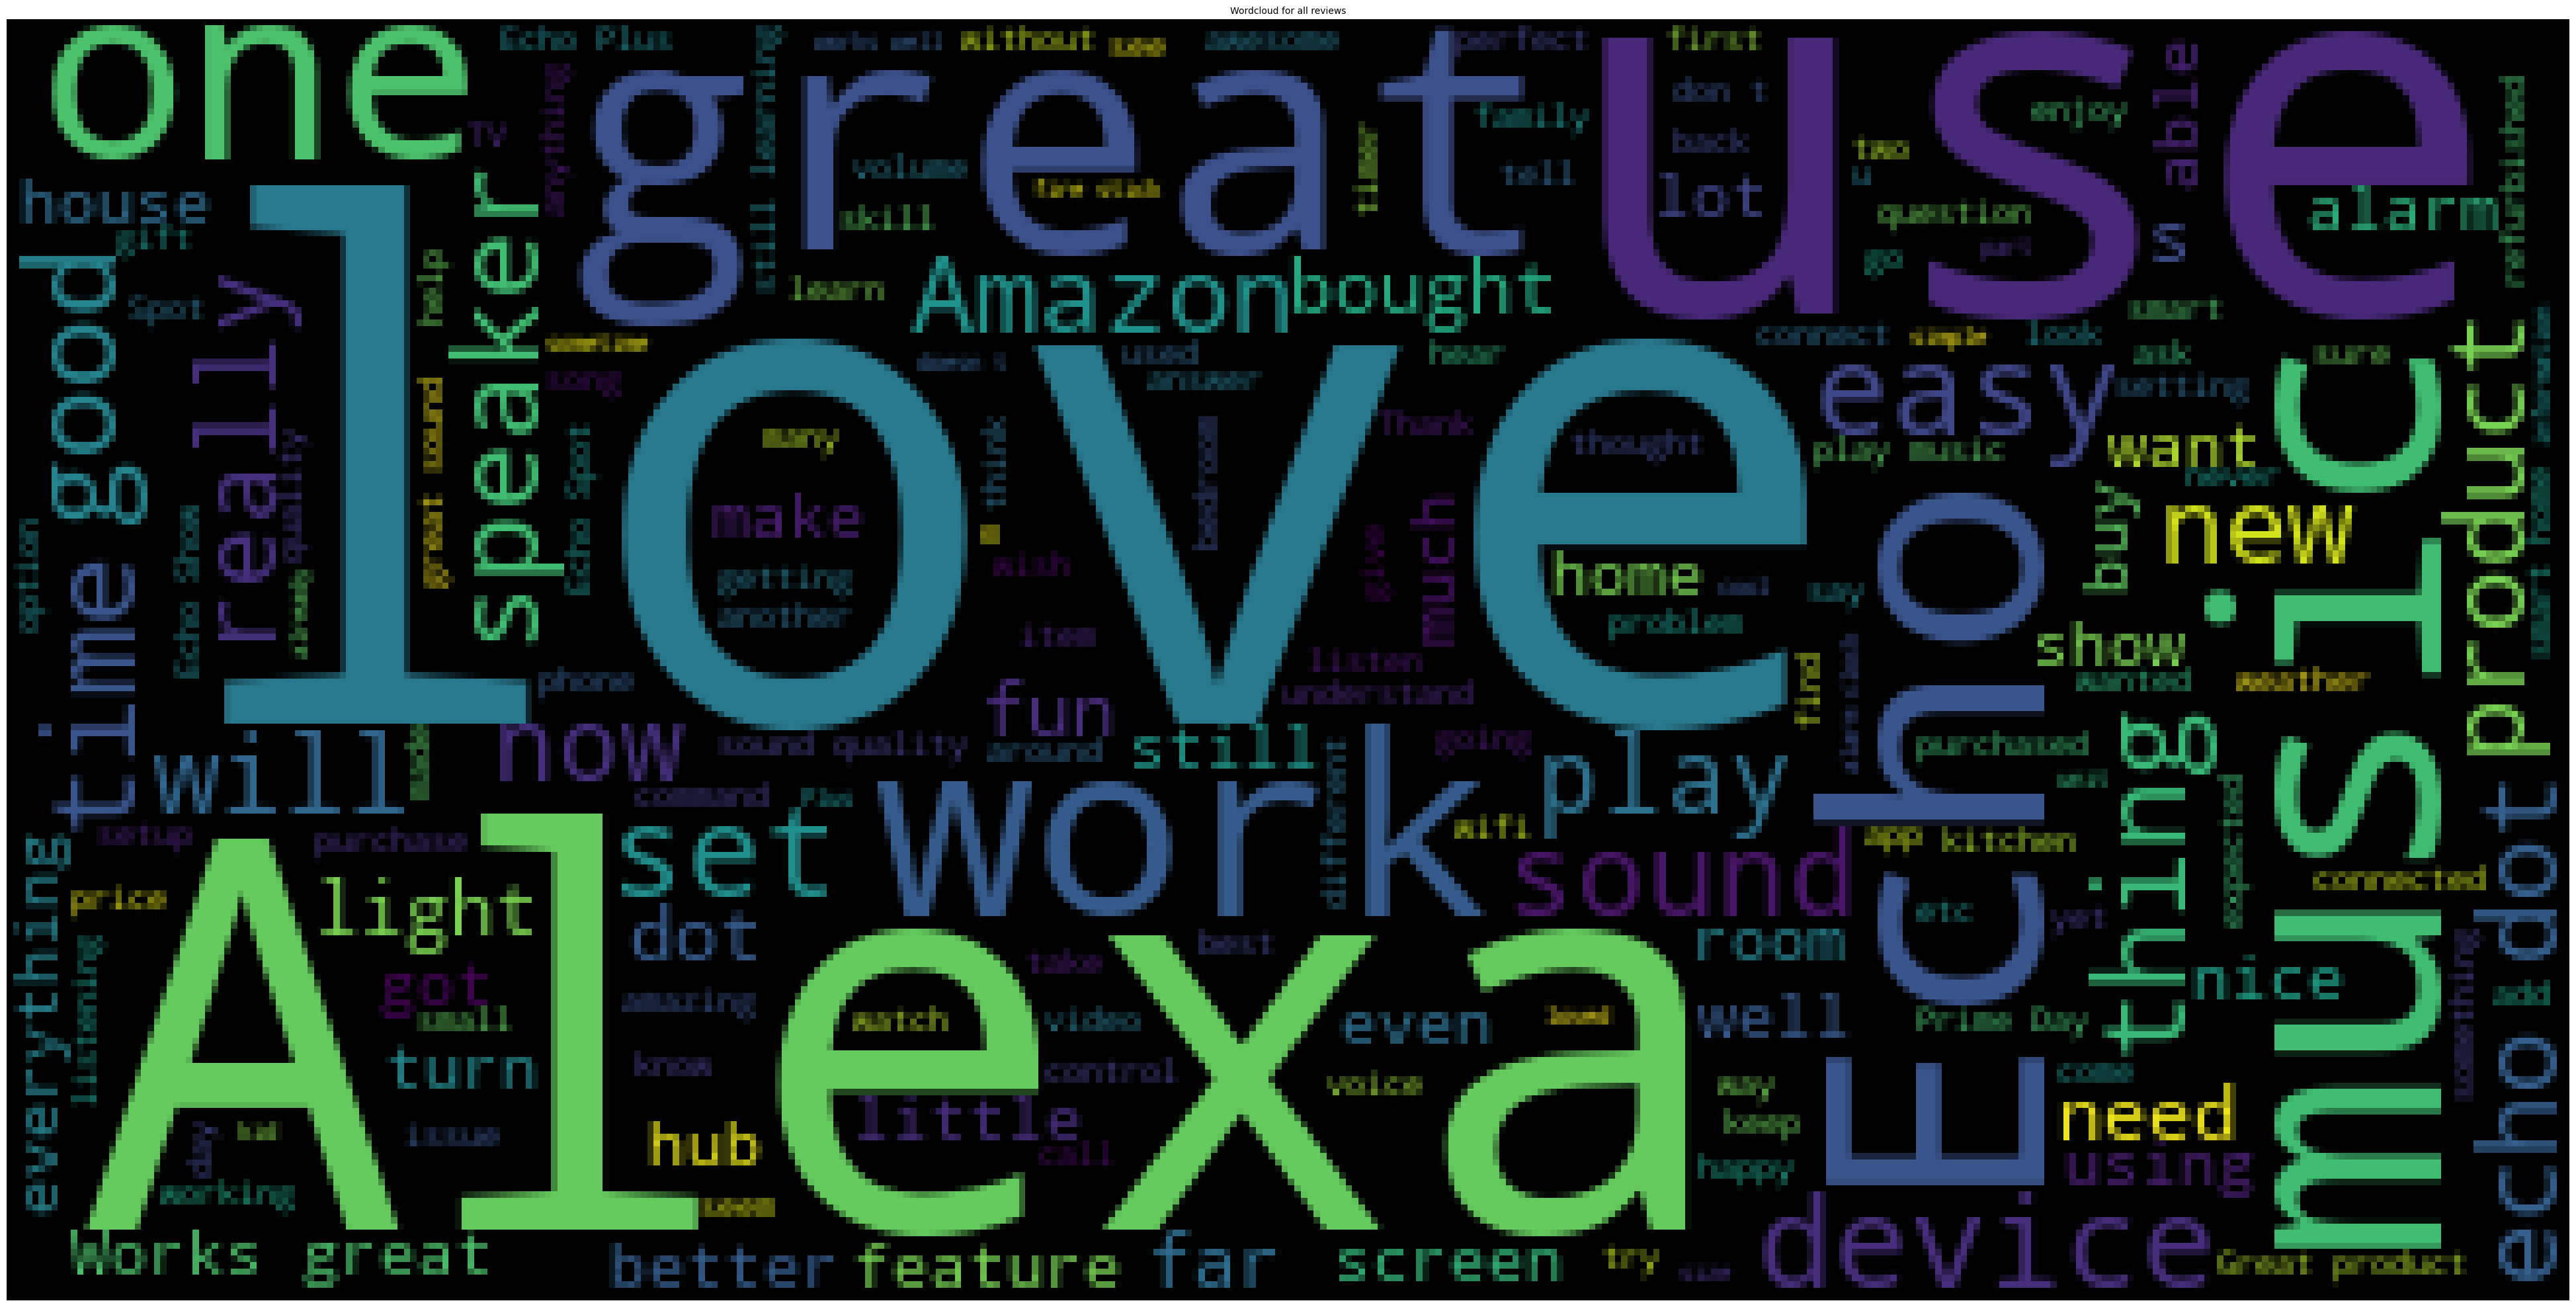

In [95]:
reviews= " ".join([review for review in data['verified_reviews']])
wc=WordCloud(background_color= 'black', max_words=1000)
plt.figure(figsize=(50,50))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [97]:
# Negative
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()
#positive
pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

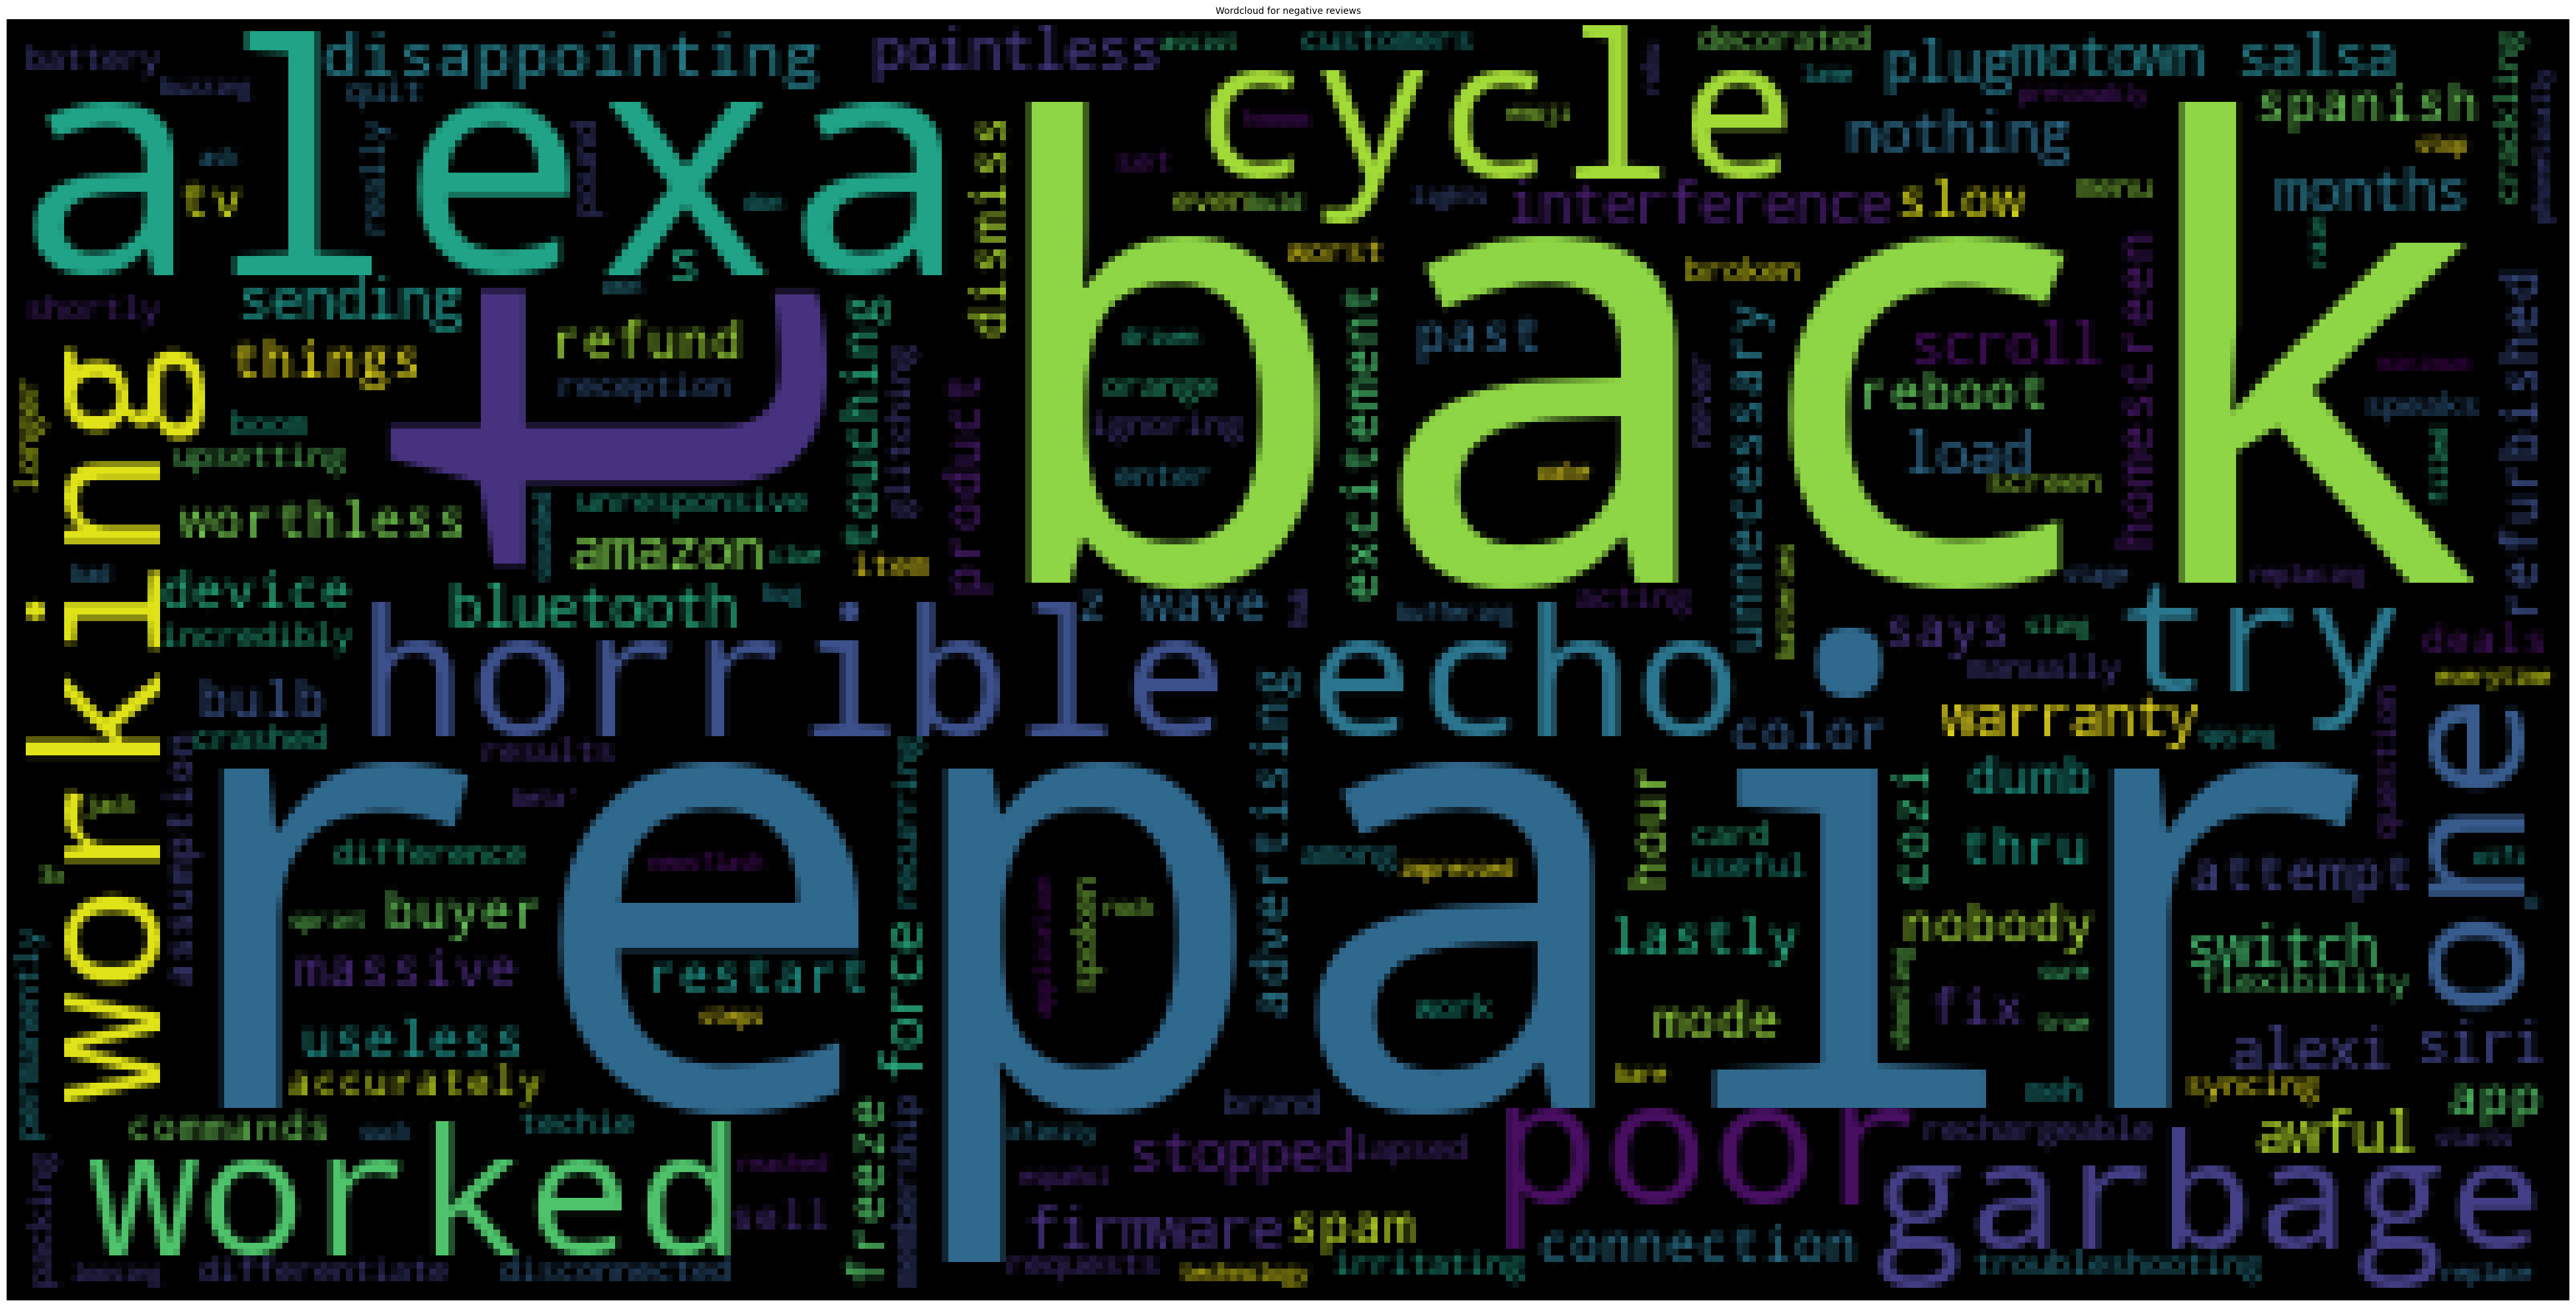

In [98]:
plt.figure(figsize=(50,50))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

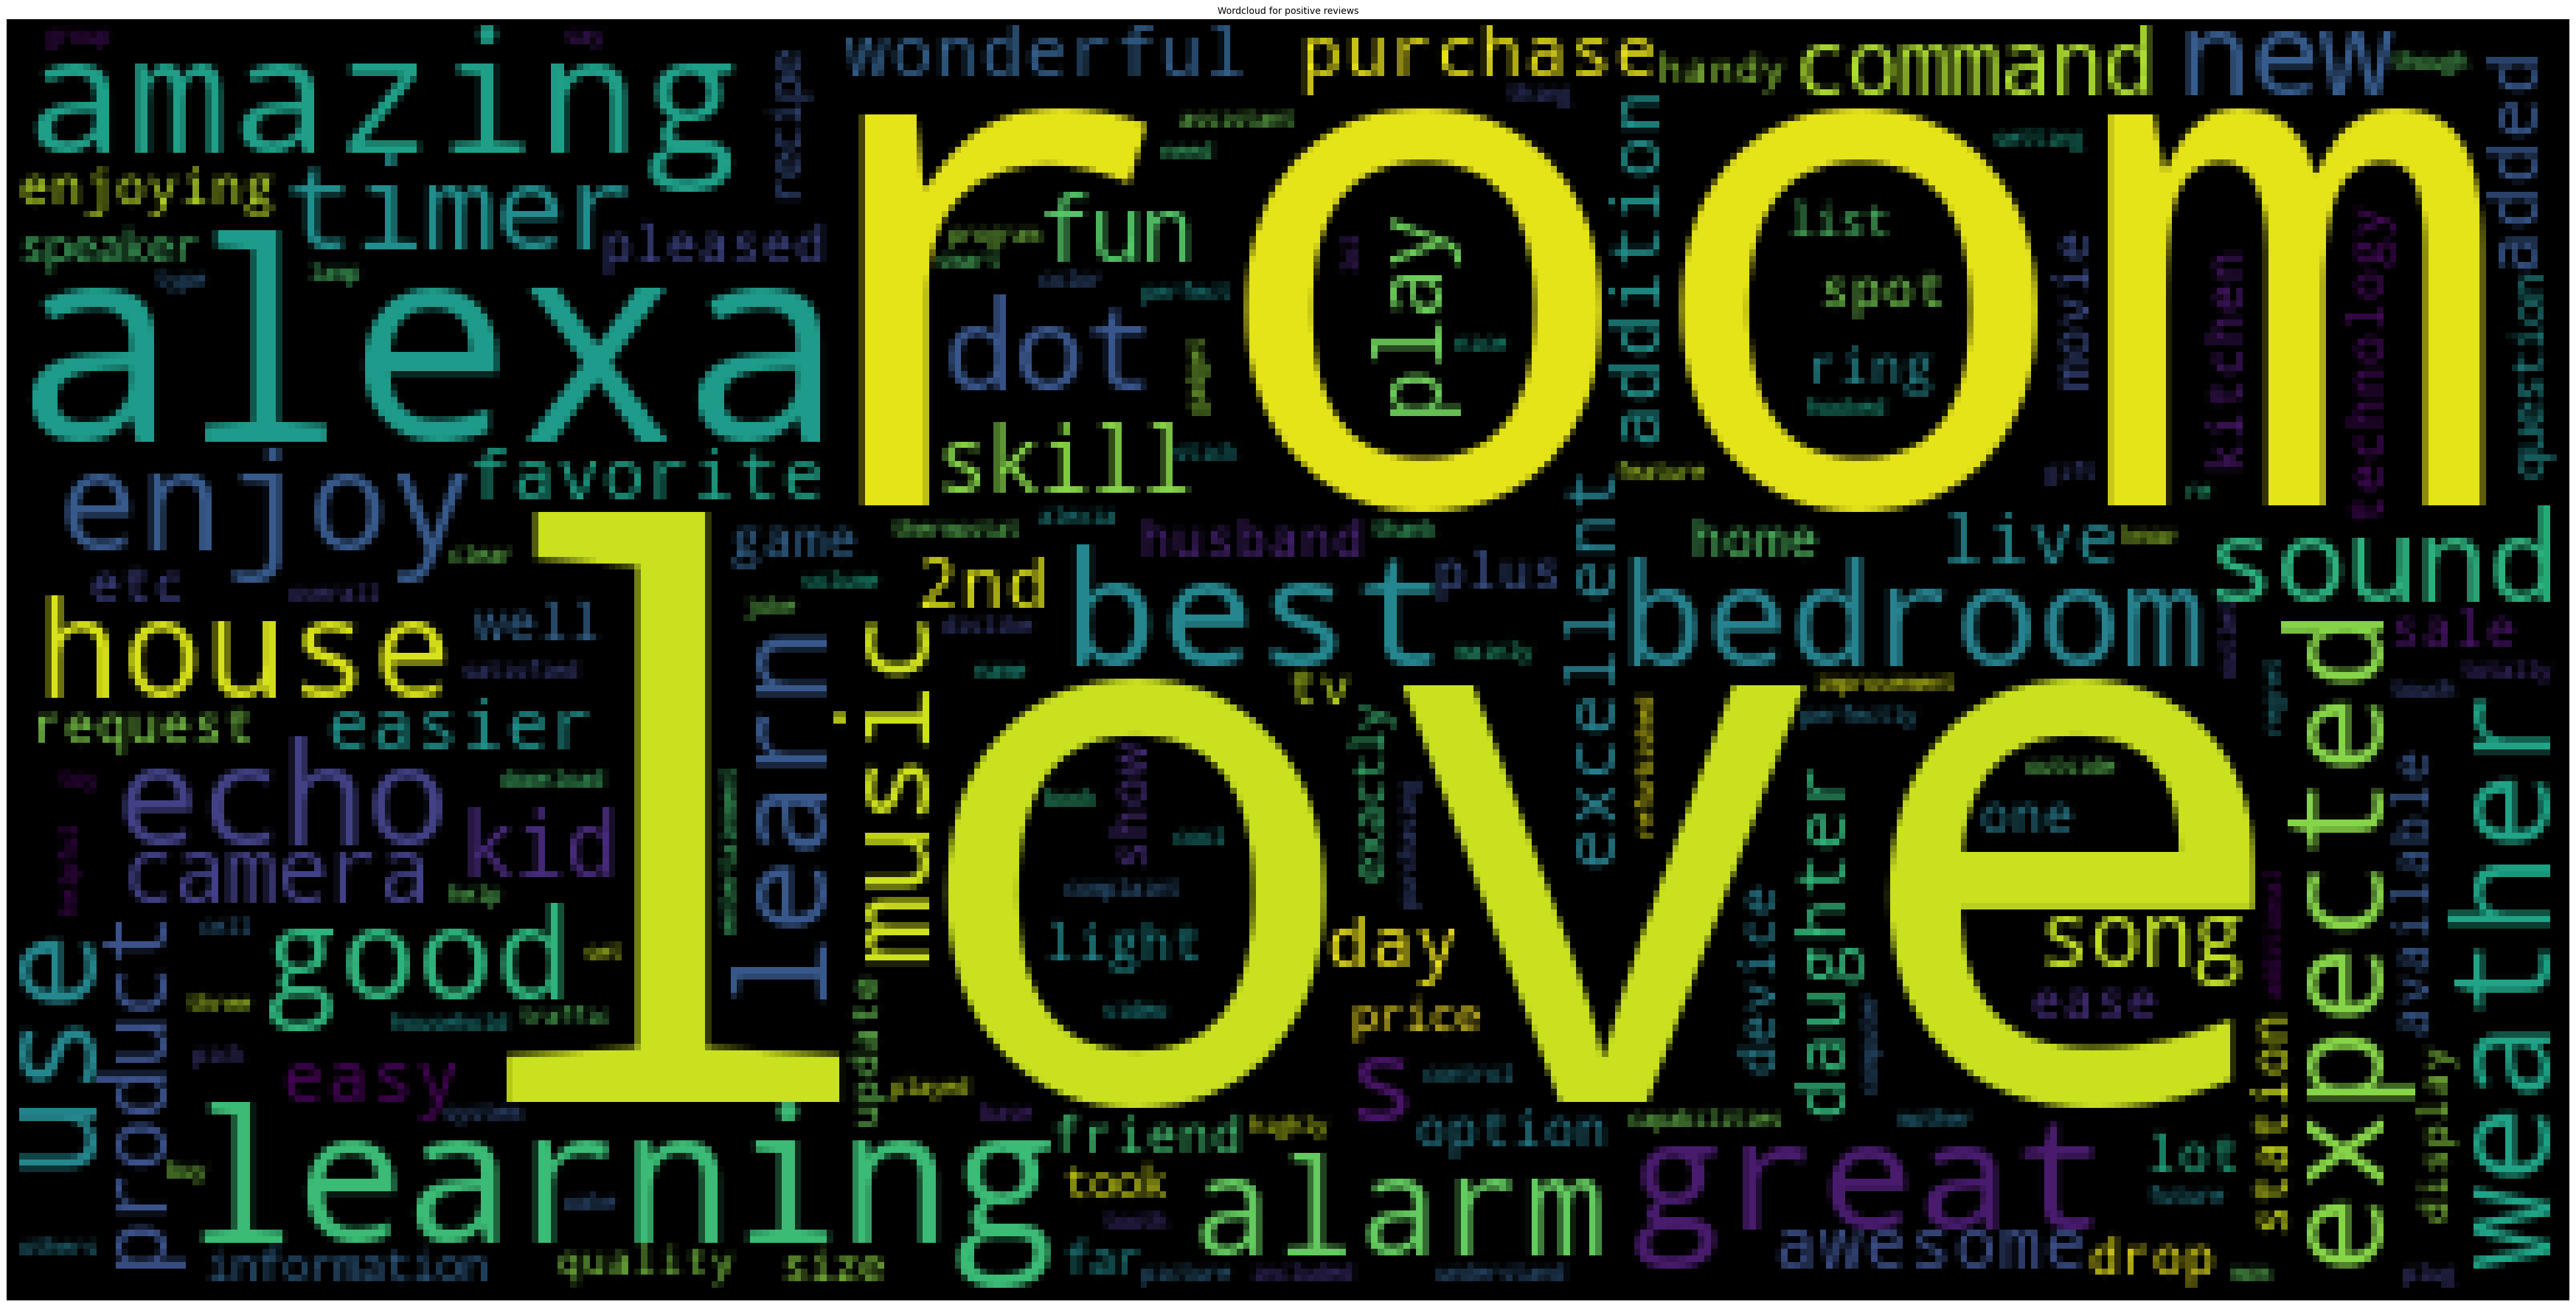

In [100]:
plt.figure(figsize=(50,50))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling

In [101]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [103]:
cv =CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X =cv.fit_transform(corpus).toarray()
y =data['feedback'].values

In [108]:
import os
import pickle

pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [109]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2519, 2500)
y train: (2519,)
X test: (630, 2500)
y test: (630,)


In [129]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 7


In [130]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [132]:
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

# RandomForest


Training Accuracy : 0.9952362048431918
Testing Accuracy : 0.9444444444444444


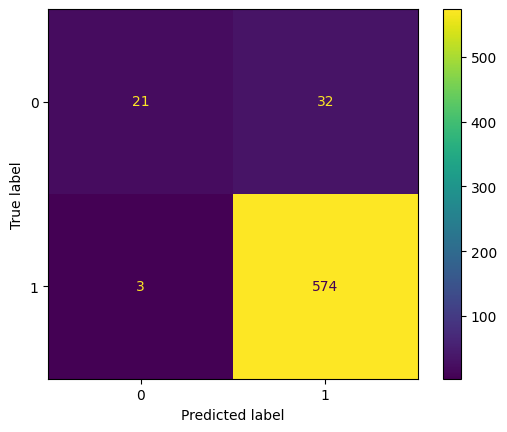

Model saved to models/model_RandomForest.pkl


In [153]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

y_preds = model_rf.predict(X_test_scl)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

model_path = os.path.join(models_dir, 'model_RandomForest.pkl')
with open(model_path, 'wb') as model_file:
    pickle.dump(model_rf, model_file)

print(f'Model saved to {model_path}')

# Extra Tree Classifire

Training Accuracy : 0.9952362048431918
Testing Accuracy : 0.9444444444444444


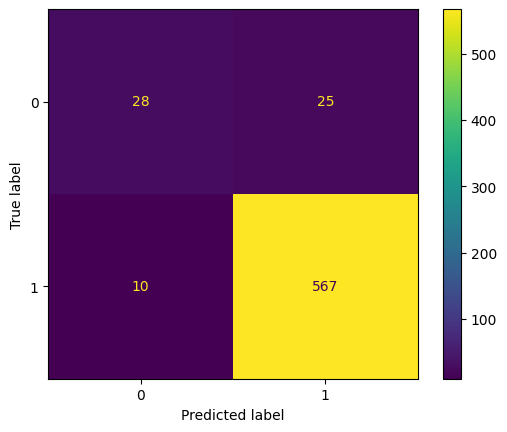

Model saved to models/model_ExtraTree.pkl


In [154]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_et = ExtraTreesClassifier()
model_et.fit(X_train_scl, y_train)

print("Training Accuracy :", model_et.score(X_train_scl, y_train))
print("Testing Accuracy :", model_et.score(X_test_scl, y_test))

y_preds = model_et.predict(X_test_scl)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_et.classes_)
cm_display.plot()
plt.show()

model_path = os.path.join(models_dir, 'model_ExtraTree.pkl')
with open(model_path, 'wb') as model_file:
    pickle.dump(model_et, model_file)

print(f'Model saved to {model_path}')

# Decision Tree

Training Accuracy : 0.9952362048431918
Testing Accuracy : 0.9238095238095239


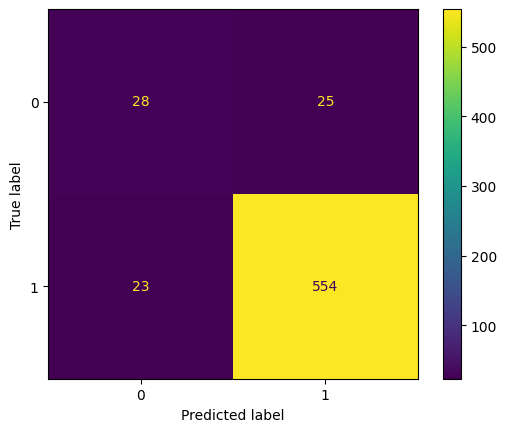

Model saved to models/model_DecisionTree.pkl


In [155]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

y_preds = model_dt.predict(X_test_scl)
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

# Save the model
model_path = os.path.join(models_dir, 'model_DecisionTree.pkl')
with open(model_path, 'wb') as model_file:
    pickle.dump(model_dt, model_file)

print(f'Model saved to {model_path}')